# Backtest Strategy
* Use bt for event-driven backtest

In [19]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from feature_engineering import Indicators
from portfolio_optimizer import portfolio_optimizer
from data_sampler import data_manager
from random_forest import random_forest
from test_indicators import TestIndicators
import bt

### Read Data

In [2]:
# read data from local file
# split into modeling set and backtest sets
data_model = data_manager().readPair(pairs = "BTCUSD ETHUSD BATUSD FILUSD MKRUSD UNIUSD ZRXUSD",
                               start='2020-11-01', end='2021-08-31')
data_bt = data_manager().readPair(pairs = "BTCUSD ETHUSD BATUSD FILUSD MKRUSD UNIUSD ZRXUSD",
                               start='2021-09-01', end='2021-12-31')
data_model.head()

Pairs:  ['BTCUSD', 'ETHUSD', 'BATUSD', 'FILUSD', 'MKRUSD', 'UNIUSD', 'ZRXUSD']
Pairs:  ['BTCUSD', 'ETHUSD', 'BATUSD', 'FILUSD', 'MKRUSD', 'UNIUSD', 'ZRXUSD']


open      high       low     close     volume
       date                                                                  
BTCUSD 2020-11-01 00:00:00  13809.43  13903.45  13695.91  13750.61  49.649784
       2020-11-01 01:00:00  13750.61  13792.38  13731.44  13782.02  22.828585
       2020-11-01 02:00:00  13782.02  13792.38  13712.43  13731.35  29.382116
       2020-11-01 03:00:00  13731.35  13751.52  13663.21  13707.80  17.133026
       2020-11-01 04:00:00  13707.80  13715.31  13634.26  13694.08  22.791535

In [3]:
# Cusum filter to sample data points
# threshold
threshold = 0.02
closes = data_model.reset_index(level=0).pivot(columns='level_0', values='close')

# sampling process
samples = data_manager().cusumFilter(closes.pct_change().dropna(), h = threshold)
samples.keys()

dict_keys(['BATUSD', 'BTCUSD', 'ETHUSD', 'FILUSD', 'MKRUSD', 'UNIUSD', 'ZRXUSD'])

In [4]:
pd.DataFrame([len(samples[i]) for i in samples], index = samples.keys(), columns=['count'])

,count
BATUSD,2933
BTCUSD,1436
ETHUSD,2041
FILUSD,2065
MKRUSD,2557
UNIUSD,3035
ZRXUSD,3050


### Generate Features
* Prediction target is the return of the next hourly bar

In [5]:
# set parameters
params = {'ADX': {'window': 10}, 'CCI': {'window': 10}, 'MACD': {'fast': 12, 'slow': 26, 'signal': 9}, 
          'MOM': {'window': 5}, 'RSI': {'window': 10}, 'WILLR': {'window': 10}, 'OBV': {}, 
          'Regression': {'window': 10}, 'Volatility': {'window': 5, 'nbdev': 1}}

modelTA = {}
btTA = {}

for ticker in data_model.index.get_level_values(0).unique():
    # get features
    # take log difference for better stationary
    modelTA[ticker] = Indicators().pool(data_model.loc[ticker], params=params).diff()
    modelTA[ticker] = modelTA[ticker].loc[samples[ticker]]
    btTA[ticker] = Indicators().pool(data_bt.loc[ticker], params=params).diff()
    
    # get targets
    modelTA[ticker]['Return'] = data_model.close.loc[ticker].pct_change().shift(-1).loc[samples[ticker]]

modelTA = pd.concat(modelTA, axis = 0).dropna()
btTA = pd.concat(btTA, axis = 0).dropna()
modelTA.tail()

ADX         CCI      MACD       MOM  \
ZRXUSD 2021-08-31 16:00:00 -1.229295   55.308290  0.000374 -0.028487   
       2021-08-31 17:00:00  1.617878 -233.488907 -0.002047 -0.020999   
       2021-08-31 18:00:00  1.574198    3.088088 -0.000474  0.004499   
       2021-08-31 20:00:00  0.810818  -86.833769 -0.000953 -0.037338   
       2021-08-31 21:00:00  0.809709    5.536751 -0.000221  0.005774   

                                  RSI      WILLR           OBV  Regression  \
ZRXUSD 2021-08-31 16:00:00  -0.308111  -4.960901   -817.377805   -0.000633   
       2021-08-31 17:00:00 -12.906242 -86.915152 -24675.373065   -0.000988   
       2021-08-31 18:00:00   5.266338  34.330896   2736.395830   -0.000385   
       2021-08-31 20:00:00  -6.240140 -43.158954   -584.477719   -0.001941   
       2021-08-31 21:00:00   2.284864  13.983903    659.504119    0.000280   

                            Volatility    Return  
ZRXUSD 2021-08-31 16:00:00    0.000219 -0.031127  
       2021-08-31 17:00:00    0.005632  0.012682  
       2021-08-31 18:00:00   -0.000377  0.008617  
       2021-08-31 20:00:00   -0.001009  0.005299  
       2021-08-31 21:00:00   -0.004976 -0.007585

### Return Forecast: Random Forest

In [6]:
# split data into training and testing sets
split_date = '2021-05-01'

training_x = modelTA.loc[modelTA.index.get_level_values(1) < split_date].iloc[:, :-1]
training_y = modelTA.loc[modelTA.index.get_level_values(1) < split_date, 'Return']
testing_x = modelTA.loc[modelTA.index.get_level_values(1) >= split_date].iloc[:, :-1]
testing_y = modelTA.loc[modelTA.index.get_level_values(1) >= split_date, 'Return']

In [7]:
training_x.shape[0], testing_x.shape[0]

(10341, 6718)

In [8]:
RF = random_forest()
model1 = RF.one_fold_RF(training_x, training_y)

In [9]:
model1.score(testing_x, testing_y)

-0.06273446789620385

### Signald
Strategy Rules: compare prediction with threshold

* Use rolling Mean +/- Standard Deviation of realized returns as the dynamic threshold
* when prediction is larger than the threshold, open long position
* when prediction is lower than the negative threshold, open short position
* always 100% invest
* Use rolling window to avoid look ahead bias

In [10]:
# backtest prediction
bt_pred = pd.DataFrame(model1.predict(btTA), index = btTA.index, columns=['Predict_Return'])
bt_pred = bt_pred.reset_index(level = 0).pivot(columns = 'level_0', values = 'Predict_Return')
bt_pred.head()

level_0,BATUSD,BTCUSD,ETHUSD,FILUSD,MKRUSD,UNIUSD,ZRXUSD
date,,,,,,,
2021-09-02 10:00:00,-0.004218,0.002412,-0.002626,-0.001136,0.005395,-0.003353,-0.001523
2021-09-02 11:00:00,0.000907,-0.000304,0.000350,-0.002408,-0.001022,0.005412,-0.002455
2021-09-02 12:00:00,-0.000949,0.000006,0.001081,0.002659,-0.001818,-0.002505,0.000291
2021-09-02 13:00:00,0.000297,0.004904,-0.002951,-0.006967,0.005997,-0.000845,0.002027
2021-09-02 14:00:00,0.001858,-0.000298,-0.000203,-0.000254,-0.007317,-0.002816,0.000604


In [11]:
# realized returns
realR = data_bt.reset_index(level=0).pivot(columns='level_0', 
                                           values='close').pct_change().align(bt_pred, join='right', axis=0)[0]
rollmean = realR.rolling(10).mean()
rollstd = realR.rolling(10).std()

# generate signals
signals_date = pd.DataFrame(np.where(bt_pred>rollmean+rollstd, 1, 0),
                            index = bt_pred.index, columns=bt_pred.columns)\
               + \
               pd.DataFrame(np.where(bt_pred<rollmean-rollstd, -1, 0),
                              index = bt_pred.index, columns=bt_pred.columns)
signals_date = signals_date.replace(0, np.nan).ffill()

# how many trades
(signals_date.dropna().diff()!=0).sum().to_frame(name = 'Number of Trades')

,Number of Trades
level_0,
BATUSD,42
BTCUSD,169
ETHUSD,89
FILUSD,73
MKRUSD,55
UNIUSD,53
ZRXUSD,47


### Portfolio Optimization
Now we have to determine the portfolio weight
* Minimum-variance optimization
* Start with historical covariance matrix
* Rebalance every week

In [12]:
opt = portfolio_optimizer()
weights = realR.resample('W').apply(lambda x: pd.Series(opt.mvp(opt.getCovMat(x))))
weights = weights.resample('D').ffill().align(signals_date, join = 'right', axis = 0)[0].ffill()
weights.columns = signals_date.columns
weights.dropna().head()

level_0,BATUSD,BTCUSD,ETHUSD,FILUSD,MKRUSD,UNIUSD,ZRXUSD
date,,,,,,,
2021-09-05 00:00:00,1.405672e-16,0.651628,0.1779,0.035966,0.111223,0.023284,-3.285586e-16
2021-09-05 01:00:00,1.405672e-16,0.651628,0.1779,0.035966,0.111223,0.023284,-3.285586e-16
2021-09-05 02:00:00,1.405672e-16,0.651628,0.1779,0.035966,0.111223,0.023284,-3.285586e-16
2021-09-05 03:00:00,1.405672e-16,0.651628,0.1779,0.035966,0.111223,0.023284,-3.285586e-16
2021-09-05 04:00:00,1.405672e-16,0.651628,0.1779,0.035966,0.111223,0.023284,-3.285586e-16


In [14]:
# real portfolio weights
portfolio_weights = weights.mul(signals_date).shift().dropna()

### Backtest

In [16]:
price = data_bt.reset_index(level=0).pivot(columns='level_0', values='close')

s = bt.Strategy('Markov_Switching_Crypto', 
                [bt.algos.RunEveryNPeriods(1),
                 bt.algos.SelectAll(),
                 bt.algos.WeighTarget(portfolio_weights),
                 bt.algos.Rebalance()])

test = bt.Backtest(s, price.loc[portfolio_weights.index])
res = bt.run(test)

In [17]:
res.display()

Stat                 pair trading
-------------------  --------------
Start                2021-09-09
End                  2021-12-31
Risk-free rate       0.00%

Total Return         -30.70%
Daily Sharpe         -1.16
Daily Sortino        -1.70
CAGR                 -69.44%
Max Drawdown         -44.36%
Calmar Ratio         -1.57

MTD                  -5.86%
3m                   -39.51%
6m                   -
YTD                  -30.70%
1Y                   -
3Y (ann.)            -
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  -69.44%

Daily Sharpe         -1.16
Daily Sortino        -1.70
Daily Mean (ann.)    -65.60%
Daily Vol (ann.)     56.36%
Daily Skew           -0.60
Daily Kurt           3.02
Best Day             10.98%
Worst Day            -15.26%

Monthly Sharpe       -2.61
Monthly Sortino      -2.61
Monthly Mean (ann.)  -167.62%
Monthly Vol (ann.)   64.30%
Monthly Skew         -1.59
Monthly Kurt         -
Best Month           -0.84%
Worst Month          -35.2

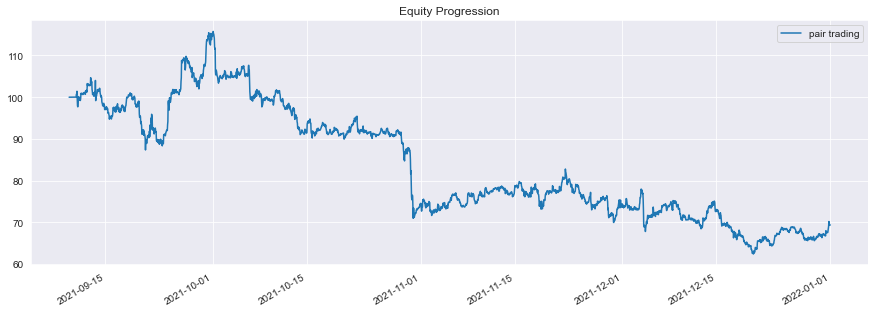

In [20]:
res.plot()